In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_FilmTrust'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'userId', 'itemId', 'rating', 'f_mean_on_self',
       'f_min_on_self', 'f_max_on_self', 'f_sum_on_self', 'f_mean_on_other',
       'f_min_on_other', 'f_max_on_other', 'f_sum_on_other', 'random_dstype',
       'flag_train', 'f_na_mean_on_self', 'f_na_min_on_self',
       'f_na_max_on_self', 'f_na_sum_on_self', 'f_na_mean_on_other',
       'f_na_min_on_other', 'f_na_max_on_other', 'f_na_sum_on_other',
       'user_idx', 'item_idx'],
      dtype='object')

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_')].tolist()

In [24]:
naCols=dftrain.columns[dftrain.columns.str.startswith('f_na')].tolist()

In [6]:
denseCols

['f_mean_on_self',
 'f_min_on_self',
 'f_max_on_self',
 'f_sum_on_self',
 'f_mean_on_other',
 'f_min_on_other',
 'f_max_on_other',
 'f_sum_on_other',
 'f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [25]:
naCols

['f_na_mean_on_self',
 'f_na_min_on_self',
 'f_na_max_on_self',
 'f_na_sum_on_self',
 'f_na_mean_on_other',
 'f_na_min_on_other',
 'f_na_max_on_other',
 'f_na_sum_on_other']

In [26]:
for myNm in naCols:
    dftrain[myNm]=dftrain[myNm].astype(int)
    dfvalid[myNm]=dfvalid[myNm].astype(int)

### Dataset and DataLoader

In [27]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [28]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols],dftrain['rating'],denseCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols],dfvalid['rating'],denseCols)

In [29]:
dftrain.shape

(32036, 24)

In [30]:
bs=32

In [31]:
dltrain=DataLoader(dstrain,bs,True)

In [32]:
dlvalid=DataLoader(dsvalid,bs,False)

## Model Architecture

In [45]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[20,25,10]
dropouts=[0.2,0.3,0.2]

In [46]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [47]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=None

In [48]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:]
        out2=self.lin2(denses)
        
        out3=torch.cat([out1,out2,biased],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [49]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [50]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [51]:
for Xb, Yb in dltrain:
    break

In [52]:
Xb.shape, Yb.shape

(torch.Size([32, 18]), torch.Size([32, 1]))

In [53]:
Xb.dtype

torch.float32

In [54]:
cfobj.forward(Xb,Yb)

(tensor([[2.2719],
         [2.0465],
         [2.2076],
         [3.2982],
         [2.7770],
         [2.3140],
         [1.9199],
         [1.6204],
         [2.2347],
         [3.8653],
         [2.6643],
         [1.5950],
         [2.3625],
         [1.4009],
         [2.2944],
         [1.7927],
         [1.7433],
         [2.2856],
         [1.9489],
         [1.4568],
         [3.9396],
         [2.1327],
         [2.0480],
         [2.4738],
         [3.4354],
         [1.7530],
         [2.3814],
         [2.3248],
         [2.3328],
         [1.8810],
         [2.2334],
         [1.5044]], grad_fn=<AddBackward0>),
 tensor(2.3087, grad_fn=<MseLossBackward>))

## Learner

In [55]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [56]:
device='cuda:0'

In [57]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [58]:
cfobj=cfobj.to(device)

In [59]:
cfobj

cf(
  (emb_user): Embedding(1509, 50)
  (emb_item): Embedding(2072, 50)
  (ub): Embedding(1509, 1)
  (ib): Embedding(2072, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=16, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [60]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [61]:
len(dltrain)

1002

In [62]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

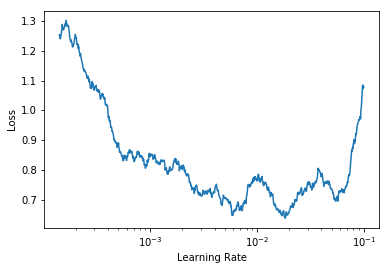

In [63]:
learner.plot_lrs(50)

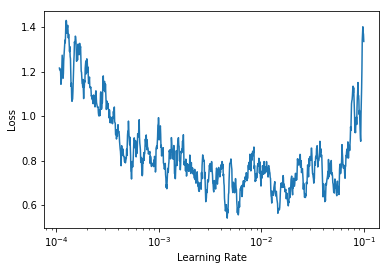

In [64]:
learner.plot_lrs(10)

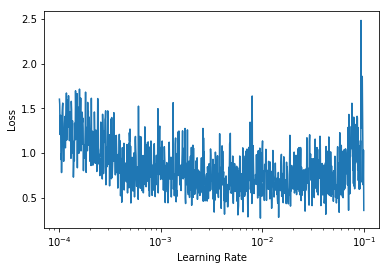

In [65]:
learner.plot_lrs(1)

In [96]:
del cfobj
torch.cuda.empty_cache()

In [97]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [98]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [99]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [100]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=7e-4,wd_mult=1.15)

In [101]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.6616842584933588                 Valid Loss:0.677140434400751 Train RMSE:0.8036533611583628 Valid RMSE:0.8116548572063237 Train MSE:0.6616842584933588 Valid MSE:0.677140434400751                 Train MAE:0.6349362084370649 Valid MAE:0.6489440235522909
Epoch:1 Learning rate 0.0018708286933869706 Weight Decay 1.1499999999999998e-07 Train Loss:0.5780789289110435                 Valid Loss:0.6713214360792702 Train RMSE:0.7526258959762856 Valid RMSE:0.8085619431448885 Train MSE:0.5780789289110435 Valid MSE:0.6713214360792702                 Train MAE:0.5873700277117674 Valid MAE:0.6473683031327134
Epoch:2 Learning rate 0.0006999999999999999 Weight Decay 1.3224999999999998e-07 Train Loss:0.5539604751709216                 Valid Loss:0.6762610870763797 Train RMSE:0.7365498661259864 Valid RMSE:0.8106007072524108 Train MSE:0.5539604751709216 Valid MSE:0.6762610870763797                 Train MAE:0.5765102499735332 Valid MAE:0.64659063

In [102]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [103]:
if 1==1:
    optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=7e-3,end_lr=9e-4,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:0.6215712630344247                 Valid Loss:0.6483753154037195 Train RMSE:0.7800787001780086 Valid RMSE:0.7944224340405979 Train MSE:0.6215712630344247 Valid MSE:0.6483753154037195                 Train MAE:0.6120822770212463 Valid MAE:0.6273098484091802
Epoch:1 Learning rate 0.0021213203435596424 Weight Decay 1.1499999999999998e-07 Train Loss:0.5150256884431172                 Valid Loss:0.6502412502918768 Train RMSE:0.7091948241953565 Valid RMSE:0.7958911004640802 Train MSE:0.5150256884431172 Valid MSE:0.6502412502918768                 Train MAE:0.5459280360244705 Valid MAE:0.6280640724602096
Epoch:2 Learning rate 0.0009 Weight Decay 1.3224999999999998e-07 Train Loss:0.447979850289291                 Valid Loss:0.6588016174255161 Train RMSE:0.6612863776227007 Valid RMSE:0.8013747310958789 Train MSE:0.447979850289291 Valid MSE:0.6588016174255161                 Train MAE:0.5051339346313191 Valid MAE:0.6255031955351523


In [104]:
learner.generate_scores=True

In [105]:
learner.run_epoch(dlvalid,False)

(0.6588016174255161, 0.6255031955351523, 0.8013747310958789)

In [106]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [107]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8119691822590841

In [86]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [87]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.637311,0.798317,0.608830,0.218306,No-cold-start
1,dnnrec,0.963974,0.981822,0.798925,0.043615,User-Cold-Start
2,dnnrec,0.944825,0.972021,0.735492,-0.012722,Item-Cold_start
3,dnnrec,1.261348,1.123097,0.972784,-0.087369,User-Item-cold-start
0,dnnrec,0.637311,0.798317,0.608830,0.218306,0
1,dnnrec,0.973683,0.986754,0.796219,0.048480,1
0,dnnrec,0.671259,0.819304,0.627742,0.197581,0


In [68]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cfobj_tl_0.8')
torch.save(learner,f=f'{DATAPATH}/inter/cfobj_tl_learner_0.8')
torch.save(optimizer,f=f'{DATAPATH}/inter/cfobj_tl_optimizer_0.8')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cfjobj_tl_state_dict_0.8')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/optimizer_tl_state_dict_0.8')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
results_concat.shape

(66, 6)

In [70]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [71]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))